<a href="https://colab.research.google.com/github/ccolomb2/s23project/blob/main/09_Square_wave_BVP_IVP_Comparison%2BRun_time_Comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook #9: Comparison of results for BVP and IVP simulations, square wave + run time comparisons

This Notebook is part of the Supporting Information for the paper *Cyclic steady state simulation and waveform design for Dynamic/Programmable Catalysis*, by C. C. Tedesco, J. R. Kitchin, and C. D. Laird [[1]](#1).

This notebook contains the code to compare two different simulation approaches for dynamic catalysis. The first one is the sequential approach, when the problem is framed as an Initial Value Problem (IVP) and `scipy.integrate.solve_ivp` [[2]](#2) is used to perform the forward integration in time of the Ordinary Differential Equations (ODEs). The second approach is the simultaneous one, in which the problem is framed as a Boundary Value Problem (BVP) using Pyomo.DAE [[3]](#3) and IPOPT [[4]](#4). The goal of this comparison is to verify that the results for cyclic steady state obtained with each simulation approach agree.

Additionally, through the code and simulations contained in this notebook, **Figure 4c** and **Figure S3**, bar plots of run time comparisons, were obtained.

Please see following code, comments and narrative text to understand and use the workflow.

## Importing necessary libraries from Python and Pyomo

In [ ]:
from munch import Munch
import numpy as np
from pyomo.environ import (ConcreteModel, Constraint, Objective, Var, Param,
                           SolverFactory, value, sin, cos, Set,
                           TransformationFactory, assert_optimal_termination, RangeSet)
from pyomo.dae import ContinuousSet, DerivativeVar
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy import signal
from tqdm import tqdm
# import idaes
from scipy.optimize import minimize
import time
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors

## Declaring parameter values

In [ ]:
class Params:
    """
    Declares reaction system and CSTR model parameters
    """

    def __init__(self,  T = 423.15, # K
                        q = 0.0008333, # L/s
                        Po = 1.01325, # bar
                        Rg_constants = 0.0083144626, # kJ/K-gmol
                        Rg_Caf = 0.083144626, # bar-L/K-gmol
                        Rg_ODEs = 0.083144626, # bar-L/K-gmol
                        kB = 1.380649e-23, # J/K
                        hp = 6.62607015e-34, # J-s
                        F = 96.485, # mC/gmol
                        alpha = 0.6,
                        beta = 100,
                        gamma = 2,
                        delta = 1.4, # eV
                        H1 = 0, # kJ/mol
                        H2 = 0, # kJ/mol
                        N = 2.76e-6, # gmol sites
                        V = 2.60e-4, # L
                        Caf = 2.8423101747069843, # mol/L
                        Cbf = 0, # mol/L
                        Ca_starf = 0, # mol/L
                        Cb_starf = 0, # mol/L
                        delS1 = -135, # J/mol-K
                        delS2 = 0, # J/mol-K
                        delS3 = 135, # J/mol-K
                        number_periods = 1,
                        nfe = 900
                        ):


        self.T = T # Temperature on the simulated CSTR
        self.Po = Po # Standard pressure
        self.Caf = Caf # Initial concentration of A
        self.Cbf = Cbf # Initial concentration of B
        self.Ca_starf = Ca_starf # Initial concentration of A*
        self.Cb_starf = Cb_starf # Initial concentration of B*
        self.Rg_constants  = Rg_constants # Gas constant used in kinetic constants calculation
        self.Rg_Caf = Rg_Caf # Gas constant used to calculate Caf
        self.Rg_ODEs = Rg_ODEs # Gas constant used in the ODEs
        self.kB = kB # Boltzmann constant
        self.hp = hp # Plank constant
        self.F = F  # Faraday constant, for unit conversion
        self.alpha = alpha # Parameter for the BEP relation, slope of line of the relashionship
        self.beta = beta # Parameter for the BEP relation, intercept of line of the relashionship
        self.gamma = gamma # Parameter for the BE relation, slope of line of the relashionship
        self.delta = delta # Parameter for the BE relation, common BE point
        self.H1 = H1 # Enthalpy of A
        self.H2 = H2 # Enthalpy of B
        self.V = V # Volume of the CSTR
        self.delS1 = delS1 # Entropy of A
        self.delS2 = delS2 # Entropy of reaction
        self.delS3 = delS3 # Entropy of B
        self.q = q # Volumetric rate of the reactor
        self.N = N # Number of active sites on the surface
        self.number_periods = number_periods # Number of periods to be simulated
        self.nfe = nfe # Number of discretization points

## Calculate the periodic kinetic constants from the forcing signal for binding energies

In [ ]:
def time_dependent_params(params, t):
    """
    Calculates rate constants from the periodic binding energy of A

    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"

    Returns:
        Munch callables for the rate constants
    """

    # Parameters as given in the class
    T = params.T
    Rg_constants = params.Rg_constants
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    amplitude = params.amplitude  # Amplitude of the wave
    offset = params.offset  # Offset of the wave: determines the values of binding energy of A
    freq_osci = params.freq_osci  # Frequency of the wave
    duty_cycle = params.duty_cycle

    # Binding energy calculation (eV)
    # Binding energy (eV)- oscillates in square wave form
    BEa = amplitude * signal.square(2 * np.pi * 1 * t, duty = duty_cycle) + offset

    # Binding energy values for B, from the linear relationship with Bea
    BEb = gamma * BEa + H2 / F - gamma * H1 / F + (1 - gamma) * delta

    # Heat of reaction (kJ/mol)
    delH1 = -BEa * F  # For the adsorption step
    delH2 = (H2 - BEb * F) - (H1 - BEa * F)  # For the surface reaction step
    delH3 = BEb * F  # For the desorption step

    # Activation energy from BEP relationship (kJ/mol)
    Ea = alpha * delH2 + beta

    # Gibbs free energy
    delG1 = delH1 - T * delS1 * 0.001  # For the adsorption step
    delG2 = delH2 - T * delS2 * 0.001  # For the surface reaction step
    delG3 = delH3 - T * delS3 * 0.001  # For the desorption step

    # Equilibrium constants (unitless)
    K1 = np.exp(-delG1 / Rg_constants / T)  # For the adsorption step
    K2 = np.exp(-delG2 / Rg_constants / T)  # For the surface reaction step
    K3 = np.exp(-delG3 / Rg_constants / T)  # For the desorption step

    # Kinetic constants (1/s)
    kf1 = ((kB * T) / hp) * np.exp(delS1 * 0.001 / Rg_constants)  # For the adsorption of A
    kf2 = ((kB * T) / hp) * np.exp(-Ea / Rg_constants / T)  # For the forward surface reaction
    kr3 = ((kB * T) / hp) * np.exp(-delS3 * 0.001 / Rg_constants)  # For the adsorption of B
    kr1 = kf1 / K1  # For the desorption of A
    kr2 = kf2 / K2  # For the reverse surface reaction
    kf3 = kr3 * K3  # For the desorption of B

    return Munch(kf1=kf1, kf2=kf2, kf3=kf3, kr1=kr1, kr2=kr2, kr3=kr3, BEa=BEa)

## Create the Pyomo model

In [ ]:
def create_pyomo_model(params):
    """
    Creates the pyomo model for the CSTR. Uses Backwards Finite Difference method to discretize the time span and
    a system of equations from the ODE system modelled here.

    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"

    Returns:
        Discretized Pyomo model
    """

    # Parameters as given in the class
    T = params.T
    q = params.q
    Po = params.Po
    Caf = params.Caf
    Cbf = params.Cbf
    Ca_starf = params.Ca_starf
    Cb_starf = params.Cb_starf
    Rg_constants = params.Rg_constants
    Rg_Caf = params.Rg_Caf
    Rg_ODEs = params.Rg_ODEs
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    amplitude = params.amplitude
    N = params.N
    V = params.V
    offset = params.offset
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    freq_osci = params.freq_osci
    duty_cycle = params.duty_cycle
    number_periods = params.number_periods
    nfe = params.nfe

    # Create Pyomo model and parameters
    m = ConcreteModel()
    m.params = params

    # Create time span
    # Scaling time to be between 0 and 1
    m.tau = ContinuousSet(bounds=(0, 1))
    # True time span, dependent of tau
    m.times = Var(m.tau)

    # Parameter fir the final time to be equal the number of periods times the wave period
    m.tf = Param(initialize = params.number_periods * 1 / params.freq_osci)

    # Define variables- concentrations varying with time,
    # initialized in values that would make sense to be the solution
    m.Ca = Var(m.tau, initialize = 2.84)
    m.Cb = Var(m.tau, initialize = 0.1)
    m.thetaA = Var(m.tau, initialize = 0.5)
    m.thetaB = Var(m.tau, initialize = 0.5)

    # Declare derivative variables
    m.dtimedtau = DerivativeVar(m.times) # For time scaling
    m.dCadt = DerivativeVar(m.Ca)
    m.dCbdt = DerivativeVar(m.Cb)
    m.dthetaAdt = DerivativeVar(m.thetaA)
    m.dthetaBdt = DerivativeVar(m.thetaB)

    # Constraint that says dtime/dtau = final time, since time = tau * final time
    @m.Constraint(m.tau)
    def _ode3(m,t):
        if t == 0:
            return Constraint.Skip
        return m.dtimedtau[t] == m.tf

    # Declare ODEs as contraints

    @m.Constraint(m.tau)
    # Define equation that is a function of the model and t
    def dCadt_eq(m,t):
        # pt gets the result of the function
        pt = time_dependent_params(m.params, t)
        # Declare theta_star since it varies with thetaA and B and therefore, with time
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        # ODE, being that `munch` format was used to get the k's from the function
        # Multiply the final time for time scaling
        return m.dCadt[t] == m.tf * ((q / V) * (Caf - m.Ca[t]) \
            - pt.kf1 * m.Ca[t] * Rg_ODEs * T * (theta_star) / Po * (N / V) + pt.kr1 * m.thetaA[t] * (N / V))

    @m.Constraint(m.tau)
    def dCbdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dCbdt[t] == m.tf * ((q / V) * (Cbf - m.Cb[t]) \
            + (pt.kf3 * m.thetaB[t] - pt.kr3 * m.Cb[t] * Rg_ODEs * T * (theta_star) / Po) * (N / V))

    @m.Constraint(m.tau)
    def dthetaAdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return  m.dthetaAdt[t] == m.tf * (pt.kf1 * m.Ca[t] * Rg_ODEs * T * (theta_star) / Po \
            - pt.kr1 * m.thetaA[t] - pt.kf2 * m.thetaA[t] + pt.kr2 * m.thetaB[t])

    @m.Constraint(m.tau)
    def dthetaBdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dthetaBdt[t] == m.tf * ((pt.kf2 * m.thetaA[t] - pt.kr2 * m.thetaB[t]) \
            - (pt.kf3 * m.thetaB[t] - pt.kr3 * m.Cb[t] * Rg_ODEs * T * (theta_star) / Po))

    # Declare discretization method and parameters
    discretizer = TransformationFactory('dae.finite_difference')
    discretizer.apply_to(m, nfe = nfe, scheme='BACKWARD')

    # Return the model
    return m

## Solving the model and calculating avTOF from the results

In [ ]:
def tof_from_decision_vars(params, tee=True):
    """
    Solves the Pyomo model and calculates avTOF from results of solving the BVP

    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"
        tee = True: Returns the ipopt log, which is advised. Use Tee = False in case you do not want to see the log.

    Returns:
        Values of turnover frequency in each point in time and value of the time-averaged turnover frequency
    """

    # Get the Pyomo model
    m = create_pyomo_model(params)

    # Key part of the simultaneous approach
    # Equality constraints for initial and final points - to enforce periodicity
    # and direct simulation of cyclic steady state
    m.CaCSS = Constraint(expr = m.Ca[m.tau.first()] == m.Ca[m.tau.last()])
    m.CbCSS = Constraint(expr = m.Cb[m.tau.first()] == m.Cb[m.tau.last()])
    m.thetaACSS = Constraint(expr = m.thetaA[m.tau.first()] == m.thetaA[m.tau.last()])
    m.thetaBCSS = Constraint(expr = m.thetaB[m.tau.first()] == m.thetaB[m.tau.last()])

    # Call IPOPT as solver for the square system
    solver = SolverFactory('ipopt')
    status = solver.solve(m, tee = tee)
    # If solving in a loop, terminate runs when unable to solve
    assert_optimal_termination(status)

    # Attributing values
    Ca = [value(m.Ca[t]) for t in m.tau]
    Cb = np.asarray([value(m.Cb[t]) for t in m.tau])
    thetaA = [value(m.thetaA[t]) for t in m.tau]
    thetaB = [value(m.thetaB[t]) for t in m.tau]
    theta_star = [value(1 - m.thetaA[t] - m.thetaB[t]) for t in m.tau]

    # Calculating TOF from the concentration of product on the gas phase
    TOF = Cb * params.q / params.N

    # Calculating the time-average by integration with the trapezoid method/ mean value theorem
    avTOF = np.trapz(TOF, m.tau)

    return [TOF, avTOF]

## For the IVP approach, establishing the ODEs for forward integration

In [ ]:
def ODEs(t, x, param):
    """
    Generates ODE system
    """

    T = param.T
    q = param.q
    Po = param.Po
    Caf = param.Caf
    Cbf = param.Cbf
    Ca_starf = param.Ca_starf
    Cb_starf = param.Cb_starf
    Rg_constants = param.Rg_constants
    Rg_Caf = param.Rg_Caf
    Rg_ODEs = param.Rg_ODEs
    kB = param.kB
    hp = param.hp
    F = param.F
    alpha = param.alpha
    beta = param.beta
    gamma = param.gamma
    delta = param.delta
    H1 = param.H1
    H2 = param.H2
    N = param.N
    V = param.V
    delS1 = param.delS1
    delS2 = param.delS2
    delS3 = param.delS3

    # Binding energy (eV)- oscillates in square wave form
    BEa = amplitude * signal.square(2 * np.pi * freq_osci * t, duty = duty_cycle) + offset

    # Binding energies (eV)- these values oscillate
    BEb = gamma * BEa + H2 / F - gamma * H1 / F + (1 - gamma) * delta

    # Heat of reaction (kJ/mol)
    delH1 = -BEa * F  # A(g) + * <--> A*
    delH2 = (H2 - BEb * F) - (H1 - BEa * F)  # A* <--> B*
    delH3 = BEb * F  # B* <--> B(g) + *

    # Activation energy (kJ/mol)
    Ea = alpha * delH2 + beta

    # Gibbs free energy of reaction
    delG1 = delH1 - T * delS1 * 0.001
    delG2 = delH2 - T * delS2 * 0.001
    delG3 = delH3 - T * delS3 * 0.001

    # Equilibrium constants (unitless)
    K1 = np.exp(-delG1 / Rg_constants / T)
    K2 = np.exp(-delG2 / Rg_constants / T)
    K3 = np.exp(-delG3 / Rg_constants / T)

    # Kinetic constants for each reaction
    kf1 = ((kB * T) / hp) * np.exp(delS1 * 0.001 / Rg_constants)  # A(g) + * --> A*
    kf2 = ((kB * T) / hp) * np.exp(-Ea / Rg_constants / T)  # A* --> B*
    kr3 = ((kB * T) / hp) * np.exp(-delS3 * 0.001 / Rg_constants)  # B(g) + * --> B*
    kr1 = kf1 / K1  # A* --> A(g) + *
    kr2 = kf2 / K2  # B* --> A*
    kf3 = kr3 * K3  # B* --> B(g) + *

    # Assigning variables
    Ca = x[0]
    Cb = x[1]
    thetaA = x[2]
    thetaB = x[3]

    # Fraction of empty sites
    theta_star = 1 - thetaA - thetaB

    # ODEs
    dCadt = (q / V) * (Caf - Ca) - kf1 * Ca * Rg_ODEs * T * (theta_star) / Po * (N / V) + kr1 * thetaA * (N / V)
    dCbdt = (q / V) * (Cbf - Cb) + (kf3 * thetaB - kr3 * Cb * Rg_ODEs * T * (theta_star) / Po) * (N / V)
    dthetaAdt = kf1 * Ca * Rg_ODEs * T * (theta_star) / Po - kr1 * thetaA - kf2 * thetaA + kr2 * thetaB
    dthetaBdt = (kf2 * thetaA - kr2 * thetaB) - (kf3 * thetaB - kr3 * Cb * Rg_ODEs * T * (theta_star) / Po)

    return [dCadt, dCbdt, dthetaAdt, dthetaBdt]

## Forward integration of the ODEs until cyclic steady state is reached

In [ ]:
def TOF_cyclic_steady_state(freq_osci, amplitude, offset, duty_cycle, num_periods, param):
    """
    Simulates oscillations until steady state is reached and returns the average TOF value
    """

    # Period- inverse of frequency (s)
    period = 1 / freq_osci

    # Maximum step size for the numerical integration- as a function of the period
    h = period / 1000

    # for loop that iterates the integration until it detects steady state or reach maximum number of iterations
    max_iterations = 10000

    # Initial values- for first iteration:
    # Initial time for integration (s)
    ti = 0

    # Initial conditions
    Caf = param.Caf
    Cbf = param.Cbf
    Ca_starf = param.Ca_starf
    Cb_starf = param.Cb_starf

    y0 = np.array([Caf, Cbf, Ca_starf, Cb_starf])

    # Declaring parameters for TOF calculation
    q = param.q
    N = param.N

    for i in tqdm(range(max_iterations)):

        # tspan goes from initial time to n periods ahead
        tspan = np.array([ti, ti + num_periods * period])

        # Solving the ODEs with solve_ivp, using Radau Method and using dese_output to be able to interpolate
        sol_square = solve_ivp(fun = ODEs, t_span = tspan, y0 = y0, method = 'Radau', max_step = h,\
                               dense_output = True, args = (Params(),))
        # Assigning results to variables
        t = sol_square.t
        Ca = sol_square.y[0]
        Cb = sol_square.y[1]
        thetaA = sol_square.y[2]
        thetaB = sol_square.y[3]

        # TOF (1/s)- as a function of final concentration of B, flow and number of sites
        TOF = Cb * q / N

        # for loop that interpolates results and calculates the average TOF for each one of the periods
        avTOF = []

        for x_period in range(1, num_periods):

            # Interpolated time is a linspace of 1000 points from beginning to end of a period
            t_interp = np.linspace(ti + ((x_period - 1) * period), ti + (x_period * period), 1000)

            # Intepolated solution in this time span using the solution from solve_ivp
            sol_interp = sol_square.sol(t_interp)

            # Calculate TOF with this new interpolated solution
            TOF_interp = sol_interp[1] * q / N

            # To get the average TOF value, the function inside the integral is the TOF divided by the time span
            fun_integral = TOF_interp / (ti + (x_period * period) - (ti + ((x_period - 1) * period)))

            # And the integration interval is a linspace of the time span
            interval_integral =  np.linspace(ti + ((x_period - 1) * period), ti + (x_period * period), len(TOF_interp))

            # Using np.trapz to integrate with the trapezoid rule
            av_TOF = np.trapz(fun_integral, interval_integral)

            avTOF.append(av_TOF)

        # Comparing if the values of average TOF found for every starting point are the same within tolerance
        # which indicates steady state and correct calculations

        if freq_osci > 50:
            abs_tol = 1e-6
            rel_tol = 1e-6
        else:
            abs_tol = 1e-3
            rel_tol = 1e-3

        # Comparing if all values of the array of average TOF values are the same as the first one
        # indicating they are all the same
        same = np.isclose(avTOF, avTOF[0], atol = abs_tol, rtol = rel_tol)

        # If all values are same within tolerance, the functio retuns results and the for loop is broken
        if same.all():
            return avTOF, t, TOF, t_interp, TOF_interp, Ca, Cb, thetaA, thetaB
            break

        # If they are not the same, the initial conditions and the initial time for integration are updated
        #. with the final values of the previous simulation
        else:
            y0 = sol_square.sol(sol_square.t[-1])
            ti = sol_square.t[-1]
    else:
        print("Reached maximum number of iterations and did not detect steady state.")

## Establish parameters of the four case-study systems

In [ ]:
params = Params()

In [ ]:
offsets = [1.2, 1.35, 1.4, 1.1]
amplitudes = [0.3, 0.4, 0.35, 0.3]
frequencies = [1000, 1500, 700, 1000]
duty_cycles = [0.5, 0.8, 0.3, 0.9]

## Get results and plots with the simultaneous (BVP) approach

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

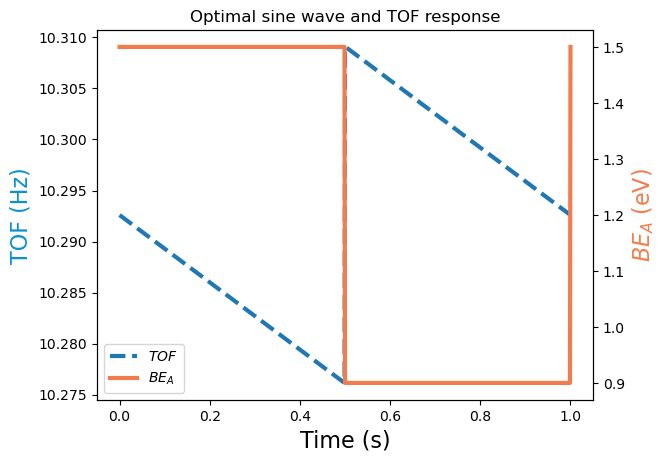

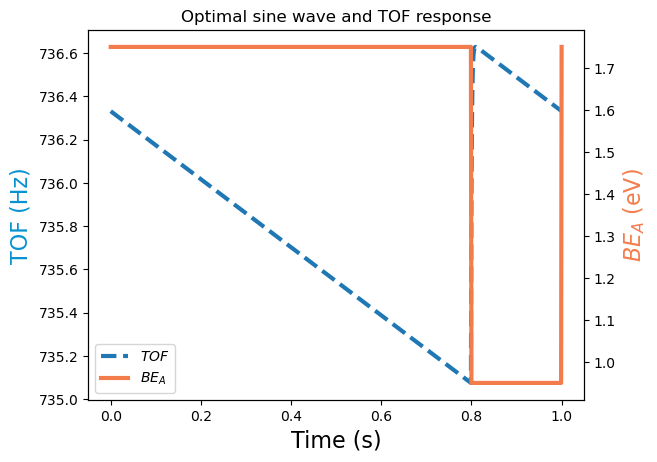

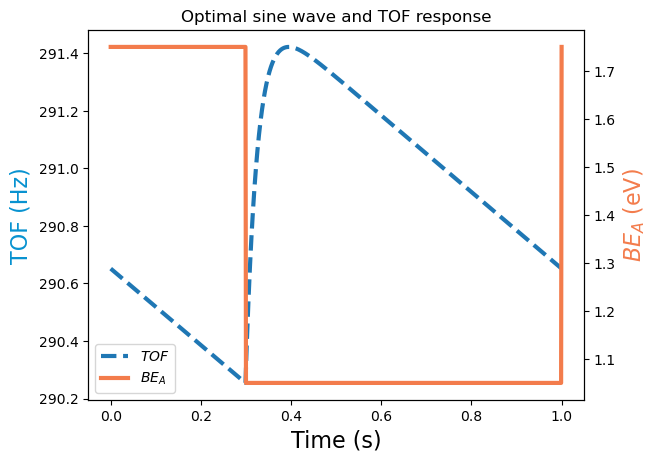

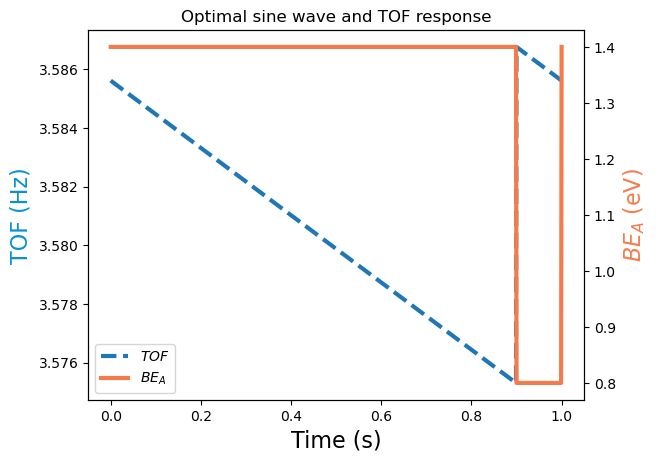

In [ ]:
avTOFs_BVP = []
elapsed_times_BVP = []

for params.offset, params.amplitude, params.freq_osci, params.duty_cycle in \
                                                    zip(offsets, amplitudes, frequencies, duty_cycles):

    start_time = time.time()
    TOF, avTOF = tof_from_decision_vars(params, tee = True)
    end_time = time.time()
    elapsed_time = end_time - start_time

    avTOFs_BVP.append(avTOF)
    elapsed_times_BVP.append(elapsed_time)

    # Returning the model to be able to get BE of A values
    m = create_pyomo_model(params)

    # Getting BE of A values for plotting
    def be(m,t):
        pt = time_dependent_params(params, t)
        Be_a = pt.BEa
        return Be_a

    BEa_array = []
    for t in m.times:
        bea = be(m, t)
        BEa_array.append(bea)

    # Creating the two plots in the same frame
    fig, ax1 = plt.subplots()

    # Creating the first plot: times x TOF plot
    ax1.plot(m.tau, TOF, label='$TOF$', linewidth=3, linestyle = '--')
    ax1.set_ylabel('TOF (Hz)', color ='#0892d0', fontsize=16)
    ax1.set_xlabel('Time (s)', fontsize=16)

    # Creating the second plot: times x BEa with axes on the right side
    ax2 = ax1.twinx()
    ax2.plot(m.tau, BEa_array, label='$BE_A$', color='#f37c4c', linewidth=3)
    ax2.set_ylabel('$BE_A$ (eV)', color='#f37c4c', fontsize=16)
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower left')
    ax2.set_title('Optimal sine wave and TOF response');

In [ ]:
print(f"The avTOFs with the simultaneous simulation approach are, \
respectively for systems 1 to 4: {[f'{avTOFs_BVP[i]:1.2f}' for i in range(len(amplitudes))]} s-1.")

The avTOFs with the simultaneous simulation approach are, respectively for systems 1 to 4: ['10.29', '735.86', '290.88', '3.58'] s-1.


## Get results and plots with the sequential (IVP) approach

  8%|███                                  | 830/10000 [13:19<2:27:11,  1.04it/s]


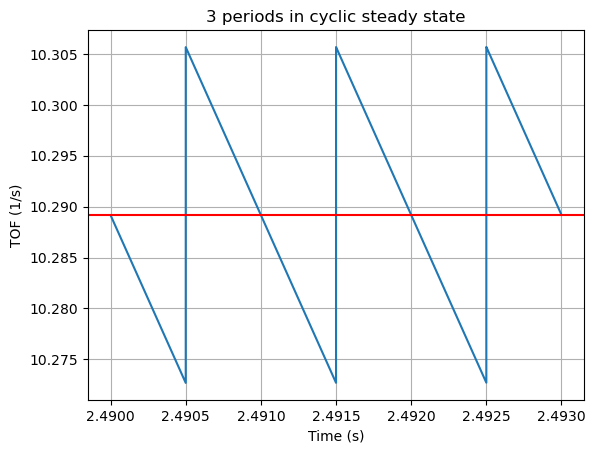

 12%|████▎                               | 1194/10000 [19:26<2:23:22,  1.02it/s]


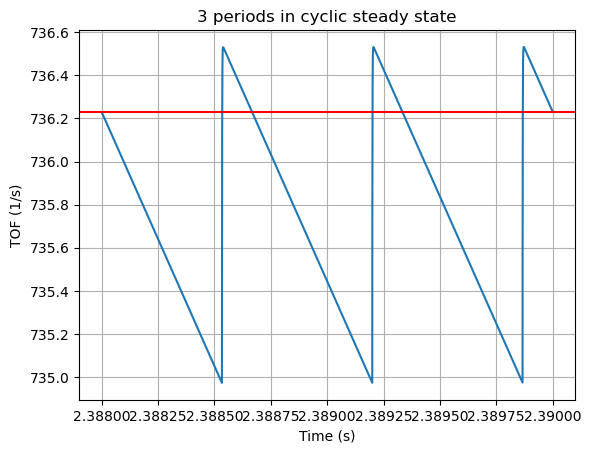

  6%|██▏                                  | 590/10000 [09:30<2:31:39,  1.03it/s]


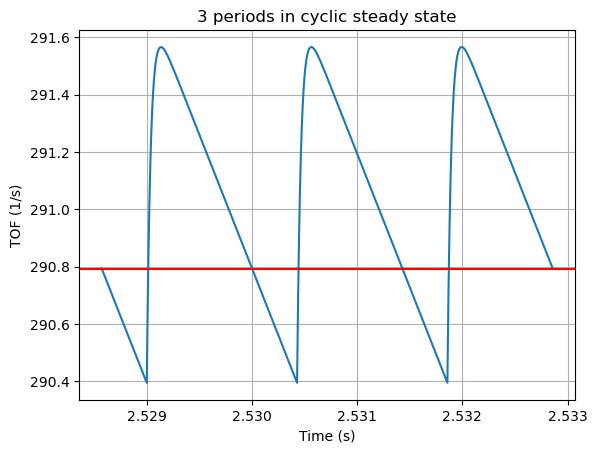

  8%|██▊                                  | 754/10000 [11:58<2:26:48,  1.05it/s]


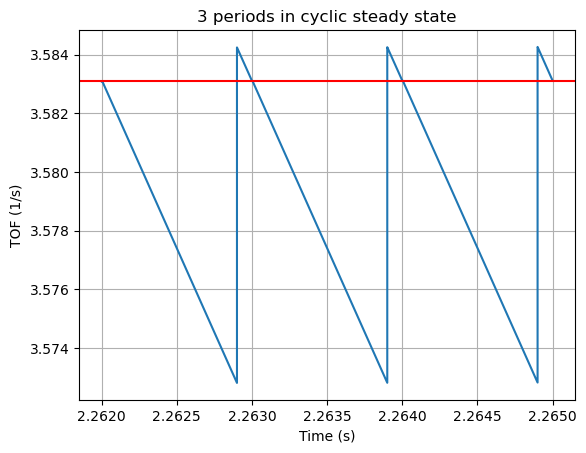

In [ ]:
# Number of periods to generate in every iteration
num_periods = 3
avTOFs_IVP = []
elapsed_times_IVP = []

for offset, amplitude, freq_osci, duty_cycle in zip(offsets, amplitudes, frequencies, duty_cycles):
    start_time = time.time()
    avTOF, t, TOF, t_interp, TOF_interp, Ca, Cb, thetaA, thetaB = \
                        TOF_cyclic_steady_state(freq_osci, amplitude, offset, duty_cycle, num_periods, Params())
    end_time = time.time()
    elapsed_time = end_time - start_time

    avTOFs_IVP.append(np.mean(avTOF))
    elapsed_times_IVP.append(elapsed_time)

    plt.plot(t, TOF)
    plt.xlabel('Time (s)')
    plt.ylabel('TOF (1/s)')
    plt.title(f'{num_periods} periods in cyclic steady state')
    plt.axhline(TOF[0], color='r')
    plt.grid()
    plt.show();

In [ ]:
print(f"The avTOFs with the simultaneous sequential approach are, \
respectively for systems 1 to 4: {[f'{avTOFs_IVP[i]:1.2f}' for i in range(len(amplitudes))]} s-1.")

The avTOFs with the simultaneous sequential approach are, respectively for systems 1 to 4: ['10.29', '735.76', '291.03', '3.58'] s-1.


## Table for comparison of results

In [ ]:
relative_errors = [abs(100 * (ivp - bvp) / bvp) for ivp, bvp in zip(avTOFs_IVP, avTOFs_BVP)]
tolerance = 1

data = {
    'Frequency (Hz)': freq_osci,
    'Amplitude (eV)': amplitude,
    'Offset (eV)': offset,
    'Duty cycle': duty_cycles,
    'IVP result - avTOF (Hz)': avTOFs_IVP,
    'BVP result - avTOF (Hz)': avTOFs_BVP,
    'Relative error (%)': relative_errors,
}

df = pd.DataFrame(data).T

df = df.round(decimals=2)

print('Comparison of results\n')
print(df)

if all(error <= tolerance for error in relative_errors):
    print("Results are considered to agree for all purposes.")

Comparison of results

                               0        1        2        3
Frequency (Hz)           1000.00  1000.00  1000.00  1000.00
Amplitude (eV)              0.30     0.30     0.30     0.30
Offset (eV)                 1.10     1.10     1.10     1.10
Duty cycle                  0.50     0.80     0.30     0.90
IVP result - avTOF (Hz)    10.29   735.76   291.03     3.58
BVP result - avTOF (Hz)    10.29   735.86   290.88     3.58
Relative error (%)          0.03     0.01     0.05     0.07
Results are considered to agree for all purposes.


## Comparison of run times (**Figure 4c**)

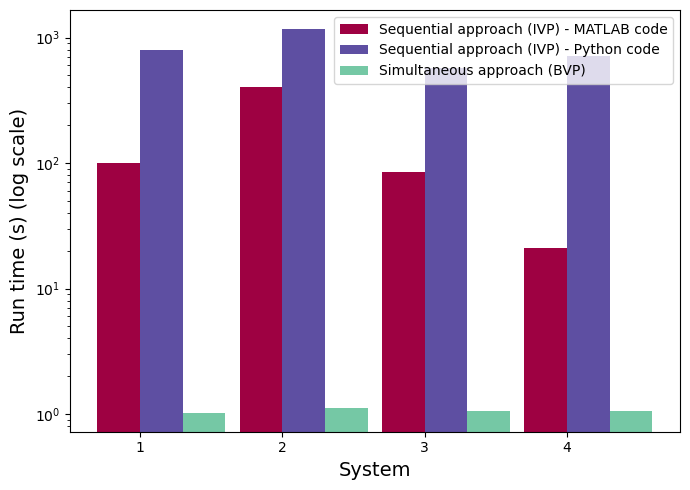

In [ ]:
x = np.array(['1', '2', '3', '4'])
y1 = np.array([100, 404, 85, 21]) # Run times for IVP in MATLAB, taken by using tic/toc in the simulations
y2 = elapsed_times_IVP
y3 = elapsed_times_BVP

bar_width = 0.3

bar1_positions = np.arange(len(x))
bar2_positions = bar1_positions + bar_width
bar3_positions = bar2_positions + bar_width

Spectral_colors = cm.get_cmap('Spectral', 10)

fig, ax = plt.subplots(figsize=(7, 5))

bars1 = plt.bar(bar1_positions, y1, width=bar_width, label='Sequential approach (IVP) - MATLAB code', color=Spectral_colors(0))
bars2 = plt.bar(bar2_positions, y2, width=bar_width, label='Sequential approach (IVP) - Python code', color=Spectral_colors(9))
bars3 = plt.bar(bar3_positions, y3, width=bar_width, label='Simultaneous approach (BVP)', color=Spectral_colors(7))

plt.ylabel('Run time (s) (log scale)', fontsize=14)
plt.xlabel('System', fontsize=14)
plt.yscale('log')
plt.xticks(bar1_positions + bar_width/2, x)
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

## Comparison of run times for a single stiff system, for a range of frequency values (**Figure 3S**)

In [ ]:
frequencies = [0.25, 1, 10, 100, 1000]

params.offset = 1.1
params.amplitude = 0.3
params.duty_cycle = 0.5

In [ ]:
avTOFs = []
elapsed_times = []

for params.freq_osci in frequencies:

    start_time = time.time()
    TOF, avTOF = tof_from_decision_vars(params, tee = True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_times.append(elapsed_time)
    avTOFs.append(avTOF)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

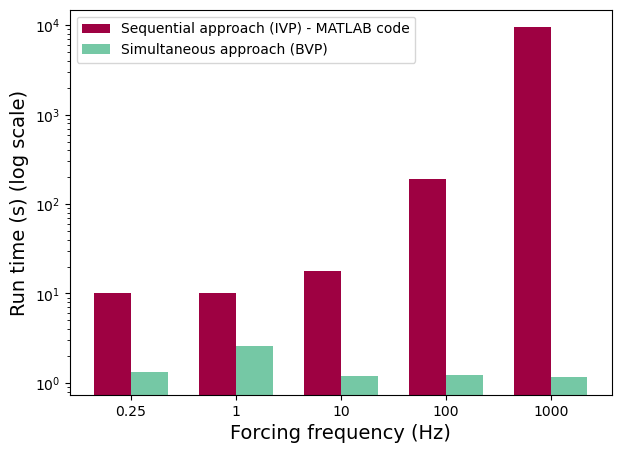

In [ ]:
x = np.array(['0.25', '1', '10', '100', '1000'])
y1 = np.array([10, 10, 18, 190, 9513]) # Run times for IVP in MATLAB, taken by using tic/toc in the simulations
y2 = elapsed_times

bar_width = 0.35

bar1_positions = np.arange(len(x))
bar2_positions = bar1_positions + bar_width

Spectral_colors = cm.get_cmap('Spectral', 10)

fig, ax = plt.subplots(figsize=(7, 5))

plt.bar(bar1_positions, y1, width=bar_width, label = 'Sequential approach (IVP) - MATLAB code', color = Spectral_colors(0))

plt.bar(bar2_positions, y2, width=bar_width, label = 'Simultaneous approach (BVP)', color = Spectral_colors(7))
plt.xlabel('Forcing frequency (Hz)', fontsize = 14)
plt.ylabel('Run time (s) (log scale)', fontsize = 14)
plt.yscale('log')
plt.xticks(bar1_positions + bar_width / 2, x)

plt.legend();

## Bibliography

<a id="1">1. link to our paper
    
<a id="2">2.  P. Virtanen, R. Gommers, T. E. Oliphant, M. Haberland, T. Reddy, D. Cournapeau, E. Burovski, P. Peterson, W. Weckesser, J. Bright, S.J. van der Walt, J. Brett, M.and Wil-
son, K. J. Millman, N. Mayorov, A. R. J. Nelson, E. Jones, R. Kern, E. Larson, C. J. Carey,
 ̇I Polat, Y. Feng, E. W. Moore, J. VanderPlas, D. Laxalde, J. Perktold, Ro. Cimrman, I. Hen-
riksen, E. A. Quintero, C. R. Harris, A. M. Archibald, A. H. Ribeiro, F. Pedregosa, P. van
Mulbregt, and SciPy 1.0 Contributors. SciPy 1.0: Fundamental Algorithms for Scientific
Computing in Python. Nature Methods, 17:261–272, 2020.B
    
<a id="3">3. Nicholson, J. D. Siirola, J. Watson, V. M. Zavala, and L. T. Biegler. pyomo.dae: a mod-
eling and automatic discretization framework for optimization with differential and algebraic
equations. Mathematical Programming Computation, 10(2):187–223, 2018.
    
<a id="4">4. A. Wachter and L. Biegler. On the implementation of an interior-point filter line-search
algorithm for large-scale nonlinear programming. Mathematical Programming, 106:25–57, 2006.